# Panel Regression

### Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from linearmodels.panel import PanelOLS
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("data/full.csv")
oil_df = pd.read_csv("data/oil.csv")
promo_elasticity_df = pd.read_csv("data/promotion_elasticity.csv")
oil_elasticity_df = pd.read_csv("data/oil_elasticity.csv")
df["date"] = pd.to_datetime(df["date"])
oil_df["date"] = pd.to_datetime(oil_df["date"])

In [3]:
df = df.merge(oil_df, on="date", how="left")
df = df.fillna(method="ffill")
df = df.fillna(method="bfill")

In [4]:
base_features = ["family", "onpromotion", "is_holiday", "type"]
target = "sales"

train_df = df.loc[df["date"] < "2017-04-16"]
test_df = df.loc[df["date"] > "2017-04-15"]
train_df = train_df.set_index(["store_nbr", "date"])
test_df = test_df.set_index(["store_nbr", "date"])

In [5]:
def get_train_test(df, date):
    df = df.copy()
    date = pd.to_datetime(date)
    train_df = df.loc[df["date"] < date]
    test_df = df.loc[df["date"] > date - pd.Timedelta("1 days")]
    train_df = train_df.set_index(["store_nbr", "date"])
    test_df = test_df.set_index(["store_nbr", "date"])
    
    return (train_df, test_df)

def train_panel_regression(train, test, features, target):
    X_train = train[features]
    X_train = pd.get_dummies(X_train)
    y_train = train[target]
    X_test = test[features]
    X_test = pd.get_dummies(X_test)
    y_test = test[target]
    
    panel_regression_model = PanelOLS(y_train, X_train, entity_effects=True, time_effects=True, check_rank=False, drop_absorbed=True)
    panel_model = panel_regression_model.fit()
    return (panel_model, panel_model.model.exog.vars)

def check_predictions(train, test, model, used_variables):
    family_prediction = pd.DataFrame()
    X_test = test.copy()
    X_test = pd.get_dummies(X_test)
    X_test = X_test[used_variables]
    average_sales = train.groupby("family")["sales"].mean()
    std_sales = train.groupby("family")["sales"].std()
    
    test["prediction"] = model.predict(X_test)
    test["mae"] = np.abs(test["sales"] - test["prediction"])
    
    family_prediction["avg_mae"] = test.groupby("family")["mae"].mean()
    family_prediction["pct_avg_sales"] = family_prediction["avg_mae"] / average_sales
    family_prediction["std_diff"] = family_prediction["avg_mae"] / std_sales
    family_prediction["worth_to_predict"] = family_prediction["std_diff"] < 1
    
    return (test, family_prediction)

def visualize_prediction(df, family, store_nbr):
    df = df.reset_index()
    fig, ax = plt.subplots(figsize=(15, 5))
    df[(df["family"] == family) & (df["store_nbr"] == store_nbr)].plot(ax=ax, x="date", y="sales", label='Real value', title=f'{family}({store_nbr}): Real / Predicted value')
    df[(df["family"] == family) & (df["store_nbr"] == store_nbr)].plot(ax=ax, x="date", y="prediction", label='Predicted value')
    ax.legend(['Real value', 'Predicted value'])
    plt.show()
    df[df["family"]==family].plot.scatter(x="sales", y="prediction")

In [6]:
base_panel, base_panel_used = train_panel_regression(train_df, test_df, base_features, target)


/var/folders/14/8l60xyhn23vgqk95vx1p0rv00000gn/T/ipykernel_24899/4059035514.py:20: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

is_holiday, family_SEAFOOD, type_A, type_B, type_C, type_D, type_E

  panel_model = panel_regression_model.fit()


In [7]:
base_test, base_family_mae = check_predictions(train_df, test_df, base_panel, base_panel_used)


In [8]:
base_family_mae

,avg_mae,pct_avg_sales,std_diff,worth_to_predict
family,,,,
AUTOMOTIVE,16.390002,2.729219,2.637273,False
BABY CARE,14.945284,142.537856,21.906402,False
BEAUTY,13.271460,3.725195,2.870022,False
BEVERAGES,1699.024311,0.740906,0.753264,True
BOOKS,14.844370,206.173708,26.347657,False
BREAD/BAKERY,333.768568,0.731628,0.914123,True
CELEBRATION,21.211054,2.662624,1.326028,False
CLEANING,607.663044,0.575975,0.838672,True
DAIRY,576.738078,0.832791,0.864547,True


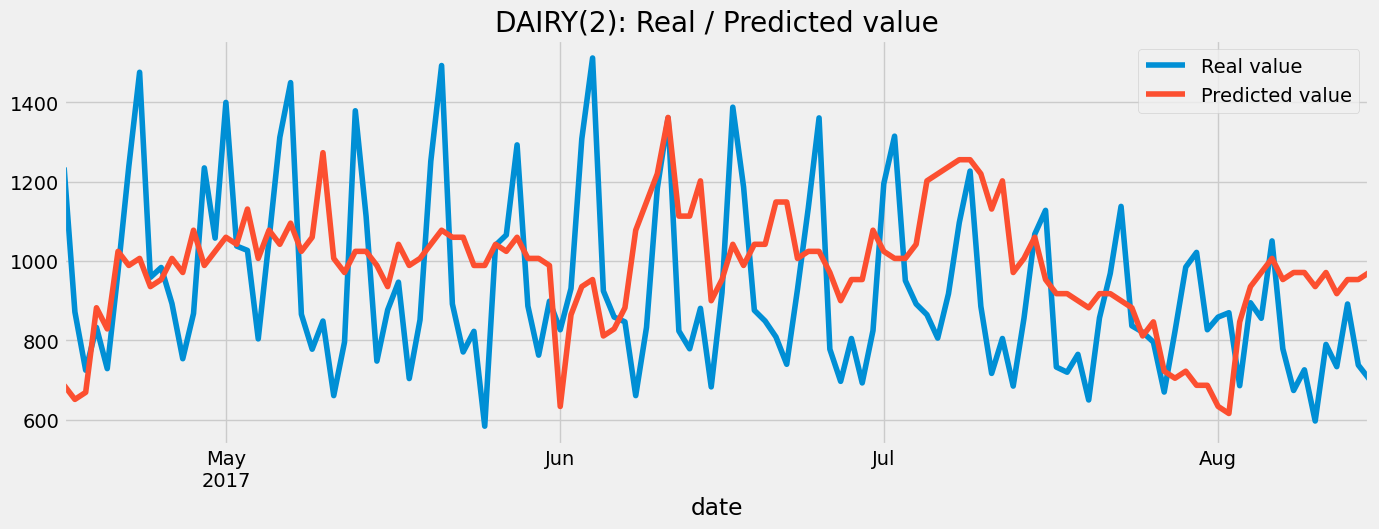

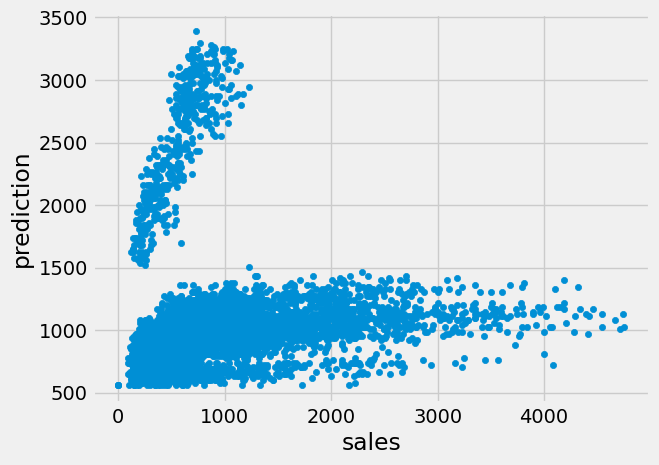

In [9]:
visualize_prediction(base_test, "DAIRY", 2)

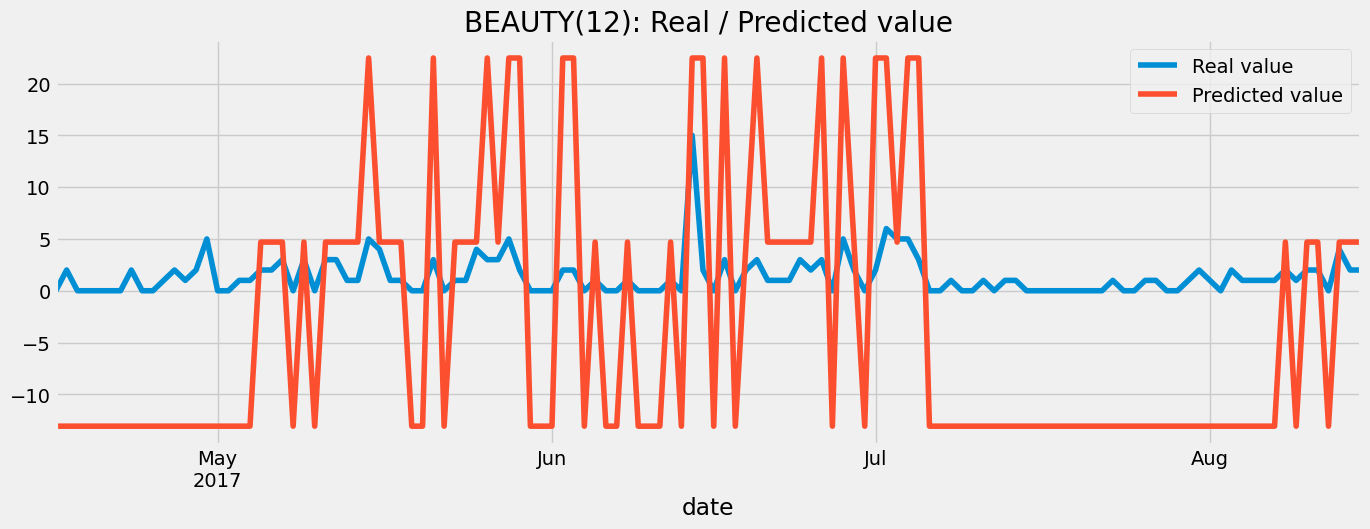

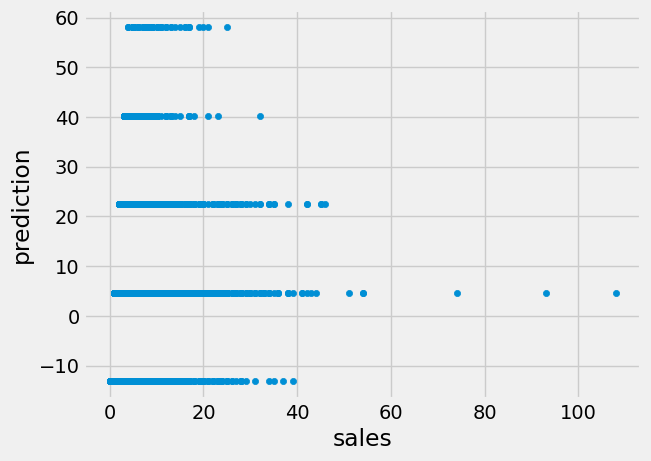

In [10]:
visualize_prediction(base_test, "BEAUTY", 12)

### Promo and Oil features

In [11]:
df = df.merge(promo_elasticity_df, on="family")
df = df.merge(oil_elasticity_df, on="family")

In [12]:
promo_features = ["mean_promo", "median_promo"]
oil_features = ["mean_oil", "median_oil"]

In [13]:
train, test = get_train_test(df, "2017-04-16")

In [14]:
models = {}
for promo in promo_features:
    for oil in oil_features:
        features = base_features +["dcoilwtico"] +[promo] + [oil]
        model, used_variables = train_panel_regression(train, test, features, target)
        models[promo+"_"+oil] = {"model": df_mae, "variables":family_stats}

/var/folders/14/8l60xyhn23vgqk95vx1p0rv00000gn/T/ipykernel_24899/4059035514.py:20: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

is_holiday, family_PRODUCE, family_SCHOOL AND OFFICE SUPPLIES, family_SEAFOOD, type_A, type_B, type_C, type_D, type_E

  panel_model = panel_regression_model.fit()
/var/folders/14/8l60xyhn23vgqk95vx1p0rv00000gn/T/ipykernel_24899/4059035514.py:20: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

is_holiday, family_PRODUCE, family_SCHOOL AND OFFICE SUPPLIES, family_SEAFOOD, type_A, type_B, type_C, type_D, type_E

  panel_model = panel_regression_model.fit()
/var/folders/14/8l60xyhn23vgqk95vx1p0rv00000gn/T/ipykernel_24899/4059035514.py:20: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

is_holiday, family_MAGAZINES, family_SCHOOL AND OFFICE SUPPLIES, family_SEAFOOD, type_A, type_B, type_C, type_D, type_E

  pan

In [15]:
model_name = "median_promo_median_oil"
complex_test, complex_family = check_predictions(train, test, models[model_name]["model"], models[model_name]["variables"])

In [16]:
complex_family

,avg_mae,pct_avg_sales,std_diff,worth_to_predict
family,,,,
AUTOMOTIVE,90.852182,15.128459,14.618791,False
BABY CARE,90.381690,861.998508,132.479094,False
BEAUTY,100.210456,28.128291,21.671035,False
BEVERAGES,1691.524474,0.737635,0.749938,True
BREAD/BAKERY,351.939145,0.771459,0.963888,True
CELEBRATION,84.878305,10.654773,5.306245,False
CLEANING,653.377686,0.619306,0.901766,True
DAIRY,619.243777,0.894168,0.928264,True
DELI,265.964461,1.019289,1.269798,False


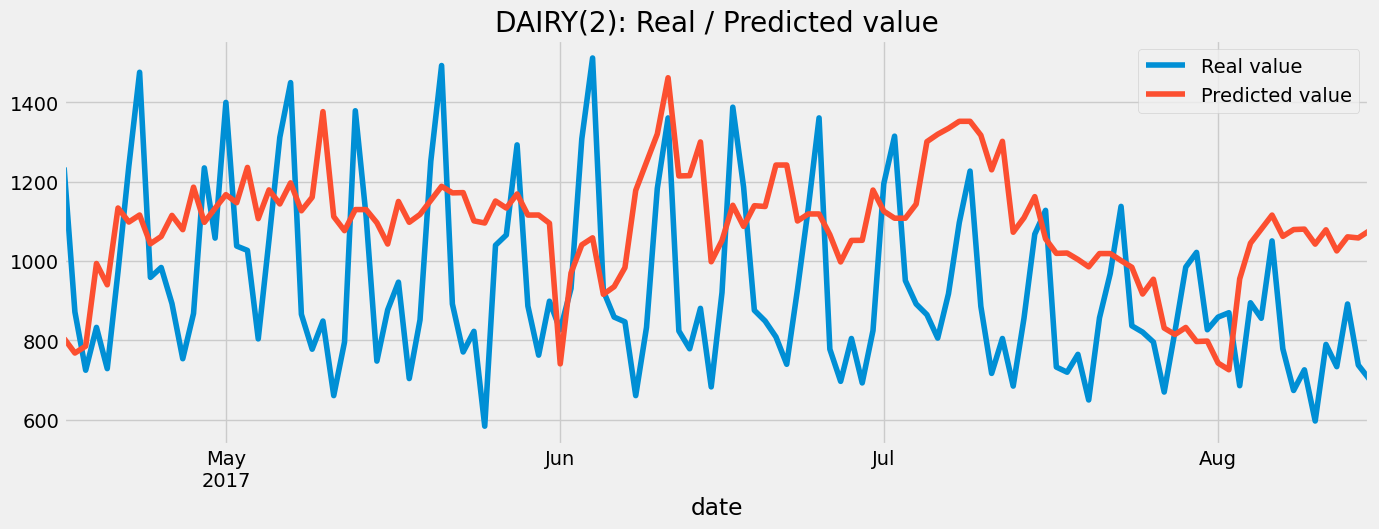

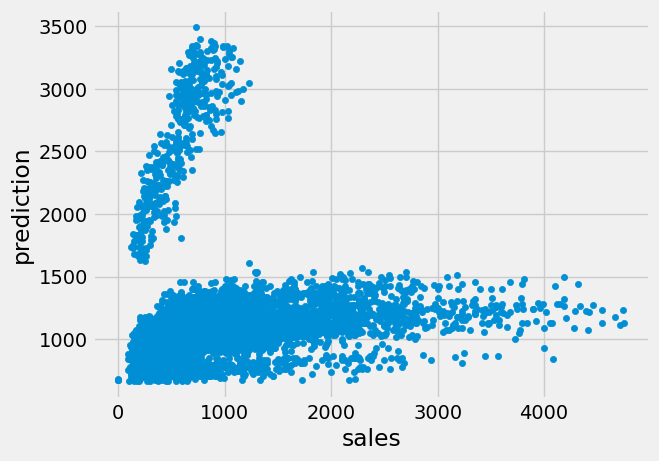

In [17]:
visualize_prediction(complex_test, "DAIRY", 2)